![](https://storage.googleapis.com/kaggle-datasets-images/955509/1617920/e3577a34996d1c3eec200d2ee8b74bec/dataset-cover.jpg?t=2020-11-04-17-03-44)

This notebook walks you through how to perform text classification with Transformers, how to monitor hyperparameters with Comet ML, and how to deploy with Gradio. 

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>1. Install Required Libraries</div></b>

In [1]:
!pip install -q comet_ml gradio

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 4.2.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>2. Initialize Comet and HuggingFace</div></b>

In [2]:
import comet_ml

comet_ml.init(project_name="text-classification-with-transfomers")

Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)


Comet API key:  ·························


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


In [3]:
from huggingface_hub import notebook_login

notebook_login()

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>3. Load Data</div></b>

In [4]:
from datasets import load_dataset

raw_datasets = load_dataset("rotten_tomatoes")

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset rotten_tomatoes_movie_review downloaded and prepared to /root/.cache/huggingface/datasets/rotten_tomatoes_movie_review/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [6]:
raw_datasets["train"][0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1}

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>4. Understand Data</div></b>

## From Datasets to Pandas DataFrames

In [7]:
import pandas as pd

raw_datasets.set_format(type="pandas")
df = raw_datasets["train"][:]
df.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [8]:
def label_int2str(row):
    return raw_datasets["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,the rock is destined to be the 21st century's ...,1,pos
1,"the gorgeously elaborate continuation of "" the...",1,pos
2,effective but too-tepid biopic,1,pos
3,if you sometimes like to go to the movies to h...,1,pos
4,"emerges as something rare , an issue movie tha...",1,pos


## Looking at the Label Distribution

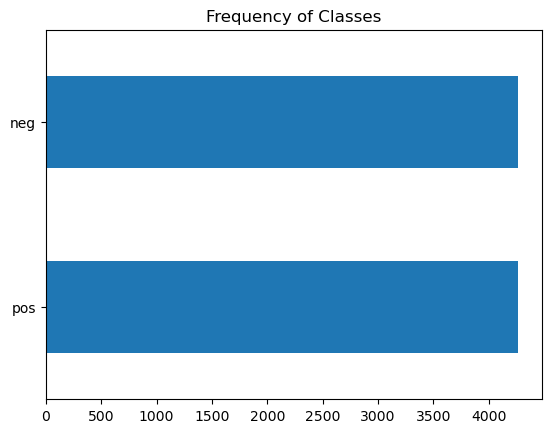

In [9]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

## How Long Are Our Texts?

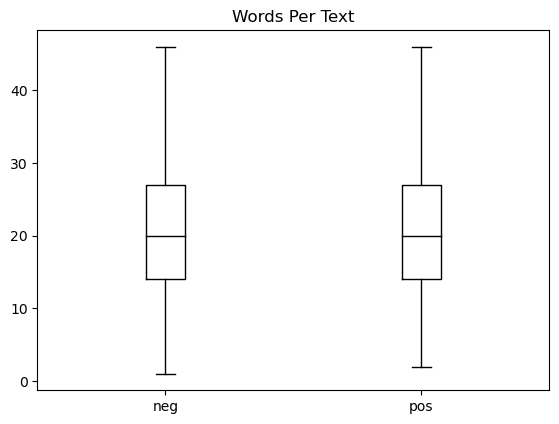

In [10]:
df["Words Per Text"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Text", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [11]:
raw_datasets.reset_format()

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>5. Preprocess Data</div></b>

In [12]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [14]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
})

In [15]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>6. Setup Evaluation Function</div></b>

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def get_example(index):
    return tokenized_datasets["test"][index]["text"]


def compute_metrics(pred):
    experiment = comet_ml.get_global_experiment()

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )
    acc = accuracy_score(labels, preds)

    if experiment:
        epoch = int(experiment.curr_epoch) if experiment.curr_epoch is not None else 0
        experiment.set_epoch(epoch)
        experiment.log_confusion_matrix(
            y_true=labels,
            y_predicted=preds,
            file_name=f"confusion-matrix-epoch-{epoch}.json",
            labels=["negative", "postive"],
            index_to_example_function=get_example,
        )

    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>7. Setup Transformer Model</div></b>

In [17]:
from transformers import AutoModelForSequenceClassification

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.we

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>8. Run Training</div></b>

In [18]:
from transformers import TrainingArguments, Trainer

%env COMET_MODE=ONLINE
%env COMET_LOG_ASSETS=TRUE

training_args = TrainingArguments(
    output_dir="my_distilbert_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to=["comet_ml"],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()

env: COMET_MODE=ONLINE
env: COMET_LOG_ASSETS=TRUE


Cloning https://huggingface.co/Tirendaz/my_distilbert_model into local empty directory.


Download file pytorch_model.bin:   0%|          | 16.0k/255M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.87k/3.87k [00:00<?, ?B/s]

Clean file training_args.bin:  26%|##5       | 1.00k/3.87k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: You are trying to log string value as a metric. This is not recommended.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tirendaz-academy/text-classification-with-transfomers/0ecea65ea5384a24a9b9d5d9e98d6799

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.399037,0.824578,0.824265,0.826908,0.824578
2,0.353400,0.395053,0.845216,0.845216,0.845217,0.845216
3,0.353400,0.441819,0.843340,0.843336,0.843370,0.843340


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=801, training_loss=0.2934642891758837, metrics={'train_runtime': 206.3449, 'train_samples_per_second': 124.016, 'train_steps_per_second': 3.882, 'total_flos': 347538569389536.0, 'train_loss': 0.2934642891758837, 'epoch': 3.0})

In [19]:
trainer.push_to_hub()

To https://huggingface.co/Tirendaz/my_distilbert_model
   4d3e39f..3dd2150  main -> main

To https://huggingface.co/Tirendaz/my_distilbert_model
   3dd2150..1b96200  main -> main



'https://huggingface.co/Tirendaz/my_distilbert_model/commit/3dd21507d9e0265c66941b22888ecc04efeed221'

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>9. Inference</div></b>

In [20]:
text = "This is a great movie. It may be my favourite."

In [21]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="Tirendaz/my_distilbert_model")
classifier(text)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


[{'label': 'POSITIVE', 'score': 0.976166307926178}]

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>10. Deploy</div></b>

In [22]:
import gradio as gr
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="Tirendaz/my_distilbert_model")

def text_classification(text):
    result= classifier(text)
    sentiment_label = result[0]['label']
    sentiment_score = result[0]['score']
    formatted_output = f"This sentiment is {sentiment_label} with the probability {sentiment_score*100:.2f}%"
    return formatted_output

examples=["This is wonderful movie!", "The movie was really bad; I didn't like it."]

io = gr.Interface(fn=text_classification, 
                         inputs= gr.Textbox(lines=2, label="Text", placeholder="Enter title here..."), 
                         outputs=gr.Textbox(lines=2, label="Text Classification Result"),
                         title="Text Classification",
                         description="Enter a text and see the text classification result!",
                         examples=examples)

io.launch(inline=False, share=True)


experiment = comet_ml.Experiment()
experiment.add_tag("text-classifier")

io.integrate(comet_ml=experiment)

Running on local URL:  http://127.0.0.1:7860


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


Running on public URL: https://cccb260e2784f81d50.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tirendaz-academy/text-classification-with-transfomers/bb24396e75134b72816e64ef545e3de8

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tirendaz-academy/text-classification-with-transfomers/bb24396e75134b72816e64ef545e3de8
COMET INFO:   Others:
COMET INFO:     Created from : Gradio
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INF

## Resources:

- [Text classification with HuggingFace](https://huggingface.co/docs/transformers/tasks/sequence_classification)
- [Integrate with Hugging Face Transformers](https://www.comet.com/docs/v2/integrations/ml-frameworks/huggingface/)
- [Natural Language Processing with Transformers](https://www.oreilly.com/library/view/natural-language-processing/9781098136789/)

Thanks for reading. Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [Twitter](http://twitter.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy)